In [62]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [63]:
try:
  connect = sqlite3.connect('../data/checking-logs.sqlite')
  print('OK. Connected to sqlite')

except sqlite3.Error as error:
  print('Error with connection:', error)

OK. Connected to sqlite


In [64]:
query = '''
SELECT uid, timestamp
FROM checker
WHERE uid LIKE 'user_%'
'''
commits = pd.io.sql.read_sql(query, connect, parse_dates=['timestamp'])
commits['weekday'] = commits['timestamp'].dt.dayofweek
commits['day'] = commits.timestamp.dt.day
commits['hour'] = commits.timestamp.dt.hour
commits['type'] = commits['weekday'].apply(
    lambda x: 'working_day' if x < 5 else 'weekend')
commits = commits.drop(columns = ['weekday'])
commits

,uid,timestamp,day,hour,type
0,user_4,2020-04-17 05:19:02.744528,17,5,working_day
1,user_4,2020-04-17 05:22:35.249331,17,5,working_day
2,user_4,2020-04-17 05:22:45.549397,17,5,working_day
3,user_4,2020-04-17 05:34:14.691200,17,5,working_day
4,user_4,2020-04-17 05:34:24.422370,17,5,working_day
...,...,...,...,...,...
3202,user_1,2020-05-21 20:19:06.872761,21,20,working_day
3203,user_1,2020-05-21 20:22:41.785725,21,20,working_day
3204,user_1,2020-05-21 20:22:41.877806,21,20,working_day
3205,user_1,2020-05-21 20:37:00.129678,21,20,working_day


In [65]:
working_day = commits[commits['type'] ==
                      'working_day'][['hour']].reset_index(drop=True)
working_day

,hour
0,5
1,5
2,5
3,5
4,5
...,...
2032,20
2033,20
2034,20
2035,20


In [66]:
weekend = commits[commits['type'] ==
                  'weekend'][['hour']].reset_index(drop=True)
weekend

,hour
0,7
1,13
2,13
3,13
4,13
...,...
1165,22
1166,22
1167,22
1168,22


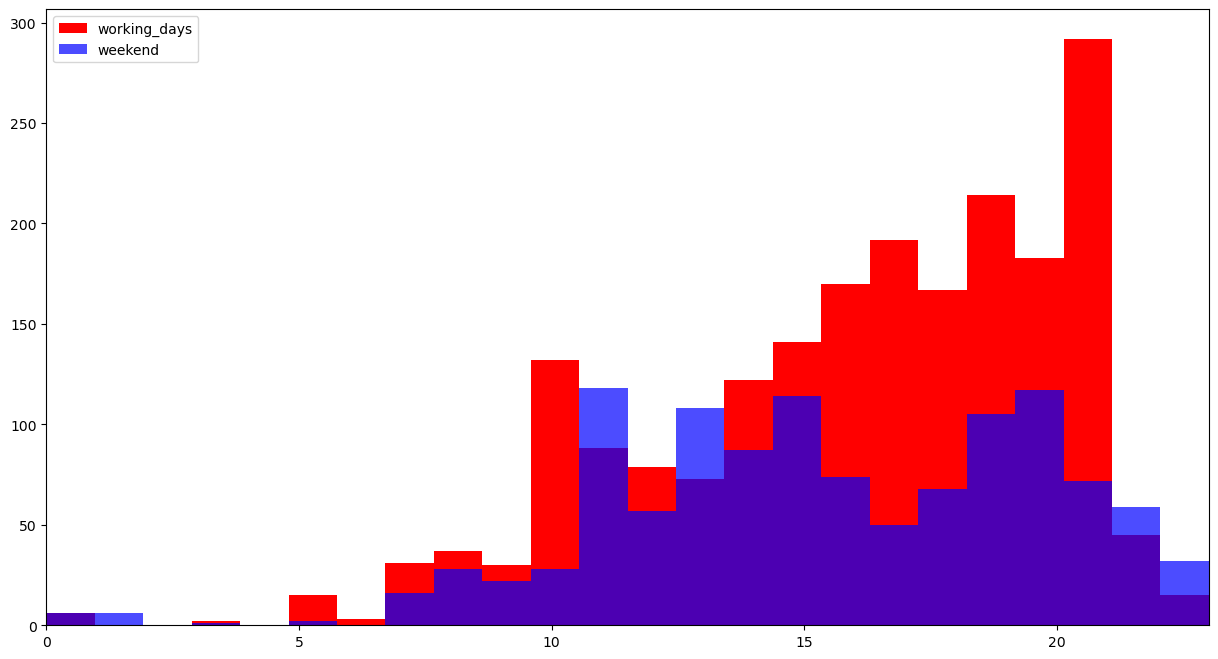

In [67]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.hist(working_day['hour'],
        bins=24,
        label='working_days',
        color='r')
ax.hist(weekend['hour'],
        bins=24,
        label='weekend',
        color='b',
        alpha=0.7)
ax.set_xlim(0, 23)
ax.legend(loc='upper left', fontsize='10')
plt.show()

In [68]:
commits_group = commits.groupby(['type', 'hour']).count()['uid'].reset_index()
pivot_table = pd.pivot_table(commits_group,
                             values='uid',
                             index='hour',
                             columns='type')
pivot_table['delta'] = pivot_table['weekend'] - pivot_table['working_day']
pivot_table.sort_values('delta', ascending=False)

type,weekend,working_day,delta
hour,,,
13,108.0,73.0,35.0
11,118.0,88.0,30.0
23,32.0,15.0,17.0
22,59.0,45.0,14.0
0,6.0,6.0,0.0
3,1.0,2.0,-1.0
9,22.0,30.0,-8.0
8,28.0,37.0,-9.0
5,2.0,15.0,-13.0


In [69]:
commits_group = commits.groupby(['type', 'hour']).count()['uid'].reset_index()
pivot_table = pd.pivot_table(commits_group,
                             values='uid',
                             index='hour',
                             columns='type')
table_w_w = pivot_table[pivot_table['weekend'] > pivot_table['working_day']]
table_w_w

type,weekend,working_day
hour,,
11,118.0,88.0
13,108.0,73.0
22,59.0,45.0
23,32.0,15.0


### Ответ. Часы, когда общее количество коммитов было выше в выходные, чем в рабочие дни: 11, 13, 22, 23



In [70]:
connect.close()